# Temporal Difference Learning


Plan:

- (1) Implement TD(0) (Policy Evaluation) 
- (2) Implement SARSA (Policy Improvement) 
- (3) Implement Q-Learning (Policy Improvement) 
- (4) Implement Expected-SARSA (Policy Improvement) 
- (5) Questions 

# Temporal Difference Learning
We will use the `Cliff` environment as featured in the book. It is designed to illustrate the differences of different temporal difference learning methods. You will need to implement evaluation and control algorithms.

## (1) TD(0) policy evaluation 

The directory `gym_gridworlds` should be a subdirectory of the folder that you started the Jupyter notebook server in.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import defaultdict
import gym_gridworlds as gg
from typing import List, Tuple, Dict
import testing
np.set_printoptions(linewidth=200)

In [2]:
def td_policy_evaluation(rng: np.random._generator.Generator, 
                        env: gym.Env, 
                        policy: np.ndarray, 
                        num_episodes: int, 
                        gamma: float=0.999, 
                        alpha: float=0.1
    ) -> Dict[int, float]:
    """
    TD(0) evaluation algorithm, which calculates the value function
    for a given policy.
    
    Args:
        rng: random number generator
        env: the openai gym environment
        policy: the policy to be evaluated
        num_episodes: number of episodes to sample
        gamma: the discount factor
        alpha: step size
    
    Returns:
        the value function associated with 'policy'
    """
    V = defaultdict(lambda: 0)
    actions = np.arange(env.action_space.n)
    for si in range(1, num_episodes + 1):
        state = env.reset()
        done = False

        while not done:
            action = rng.choice(actions, p=policy[state])
            new_state,reward,done,_ = env.step(action = action)
            V[state] = V[state] + alpha * (reward + gamma * V[new_state] - V[state])
            state = new_state

    return V



In [3]:
# let's create an environment
cliff_env = gym.make('Cliff-v0')

num_episodes = 1
alpha = 0.9
gamma = 0.999
epsilon = 0.1

# let's set a random see
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# let's create the example policy
policy = gg.random_policy(cliff_env)

# and now let's see how good the example policy really is
policy_value = td_policy_evaluation(rng, 
                                    cliff_env, 
                                    policy, 
                                    num_episodes,
                                    gamma,
                                    alpha)

assert len(policy_value) > 0, "Your implementation generates an empty value function"
for state, val in policy_value.items():
    assert testing.is_type(state, [np.int64, int])
    assert testing.is_type(val, [float, int])


### Now let's try TD(0) to evaluate the random policy


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


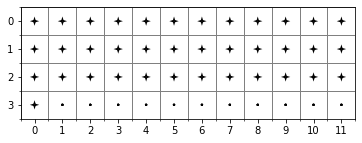

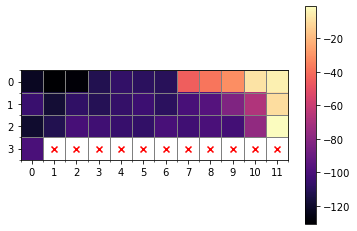

In [4]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.999
epsilon = 0.1

seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

policy = gg.random_policy(cliff_env)
V = td_policy_evaluation(rng, 
                         cliff_env, 
                         policy, 
                         num_episodes=num_episodes, 
                         gamma=gamma, 
                         alpha=alpha)

gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

In [5]:
def eps_greedy_from_qs(rng: np.random._generator.Generator, 
                       qs: np.ndarray, 
                       epsilon: float):
    """
    a helper functions that define epsilon greedy policies 
    from Q values. this function breaks ties uniformly at 
    random (if qs are all equal) you should use it where appropriate!
    
    Args:
        rng: random number generator
        qs: an action-value function
        epsilon: probability of selecting a random action
    
    Returns:
        policy
    
    """
    # find all currently optimal actions
    optimal_actions = np.argwhere(qs == np.amax(qs))
    
    # choose any of the optimal actions uniformly at random
    optimal_action = rng.choice(optimal_actions)
    
    # build an eps-soft policy:
    
    # compute eps/A(s)
    eps_p = epsilon / len(qs)
    
    # fill empty array of the same shape as 'qs' with eps/|A(s)|
    ps = np.full_like(qs, eps_p)
    
    # assign most probability mass to optimal action
    ps[optimal_action] += 1 - epsilon
    return ps

## (2) SARSA 

In [6]:
def sarsa(rng: np.random._generator.Generator, 
                        env: gym.Env, 
                        num_episodes: int, 
                        gamma: float=0.999, 
                        alpha: float=0.1,
                        epsilon: float=0.1
    ) -> Dict[int, float]:
    """
    SARSA algorithm, which calculates the value function
    and a policy.
    
    Args:
        rng: random number generator
        env: the openai gym environment
        num_episodes: number of episodes to sample
        gamma: the discount factor
        alpha: step size
        epsilon: probability of random action
    
    Returns:
        the policy 
        the state-action value function
    """
    
    # this is how we store the state-action value function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # this is simply a helper array that helps us sample from available actions, given a policy
    actions = np.arange(env.action_space.n)
    
    for si in range(1, num_episodes + 1):
        if si % 10000 == 0:
            print('{}/{} Episodes'.format(si, num_episodes))

        state = env.reset()

        # a = ? -> a sample from an eps-greedy policy, 
        # based on the current Q values
        # you may want use the helper function defined above, to do this conveniently
        
        greedy_policy = eps_greedy_from_qs(rng,Q[state],epsilon)
        action = rng.choice(actions, p=greedy_policy)
        
        done = False
        while not done:
            new_state,reward,done,_ = env.step(action = action)

            greedy_policy = eps_greedy_from_qs(rng,Q[new_state],epsilon)
            new_action =  rng.choice(actions, p=greedy_policy)
            
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * Q[new_state][new_action] - Q[state][action])

            state = new_state
            action = new_action
        



    # after all the episodes, there might be states missing from 'policy', as exploration
    # could have missed some states. so if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # make a deterministic policy, based on the Q values
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q




In [7]:
# let's create an environment
cliff_env = gym.make('Cliff-v0')

num_episodes = 1
alpha = 0.1
gamma = 0.999
epsilon = 0.5

# let's set a random see
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
policy, Q = sarsa(rng, 
                cliff_env, 
                num_episodes,
                gamma,
                alpha, 
                 epsilon)

assert len(Q) > 0, "Your implementation generates an empty value function"
for state, val in Q.items():
    assert testing.is_type(state, [np.int64, int])
    assert testing.is_type(val, np.ndarray)


### Setup and Run



------------------------------
SARSA
num_episodes 5000
alpha 0.1
gamma 0.999


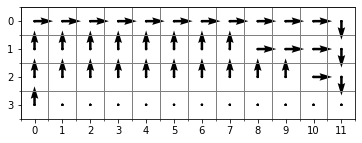

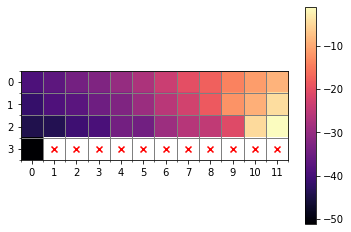

In [8]:
# let's create an environment
cliff_env = gym.make('Cliff-v0')

# SARSA needs many episodes
num_episodes = 5000
# SARSA needs a small step size
alpha = 0.1
gamma = 0.999
# SARSA needs to explore a lot with this small amount of episodes
# if this is set too low, we'll end up with policies that will
# produce infinite loops, once we try to evaluate the policy with
# TD policy evaluation!
# (i.e. policies that loop between two or more states)
epsilon = 0.1

# let's set a random see
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

epsilon = 0.5

print('\n\n' + '-' * 30)
print('SARSA')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)
policy, Q = sarsa(rng, 
                  cliff_env, 
                  num_episodes, 
                  gamma=gamma, 
                  alpha=alpha, 
                  epsilon=epsilon)

# V = td_policy_evaluation(rng, cliff_env, policy, num_episodes, gamma=gamma, alpha=alpha)
V = defaultdict(lambda: 0)
for s, qs in Q.items():
    V[s] = np.max(qs)

gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

## (3) Q-Learning 

In [9]:
def q_learning(rng: np.random._generator.Generator, 
                        env: gym.Env, 
                        num_episodes: int, 
                        gamma: float=0.999, 
                        alpha: float=0.1,
                        epsilon: float=0.1
    ) -> Dict[int, float]:
    """
    Q-LEARNING algorithm, which calculates the value function
    and a policy.
    
    Args:
        rng: random number generator
        env: the openai gym environment
        num_episodes: number of episodes to sample
        gamma: the discount factor
        alpha: step size
        epsilon: probability of random action
    
    Returns:
        the policy 
        the state-action value function
    """

    # this is how we store the state-action value function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # this is simply a helper array that helps us sample from available actions, given a policy
    actions = np.arange(env.action_space.n)
    
    for si in range(1, num_episodes + 1):
        if si % 10000 == 0:
            print('{}/{} Episodes'.format(si, num_episodes))

        state = env.reset()
        done = False
        while not done:
            greedy_policy = eps_greedy_from_qs(rng,Q[state],epsilon)
            action =  rng.choice(actions, p=greedy_policy)

            new_state,reward,done,_ = env.step(action = action)
            
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * np.max(Q[new_state]) - Q[state][action])

            state = new_state
        



    # after all the episodes, there might be states missing from 'policy', as exploration
    # could have missed some states. so if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # make a deterministic policy, based on the Q values
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q

In [10]:
# let's create an environment
cliff_env = gym.make('Cliff-v0')

num_episodes = 1
alpha = 0.9
gamma = 0.999
epsilon = 0.1

# let's set a random see
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
policy, Q = q_learning(rng, 
                        cliff_env, 
                        num_episodes,
                        gamma,
                        alpha, 
                        epsilon)

assert len(Q) > 0, "Your implementation generates an empty value function"
for state, val in Q.items():
    assert testing.is_type(state, [np.int64, int])
    assert testing.is_type(val, np.ndarray)


### Setup and Run


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


------------------------------
Q-Learning
num_episodes 1000
alpha 0.9
gamma 0.999


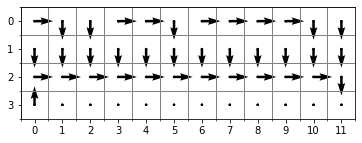

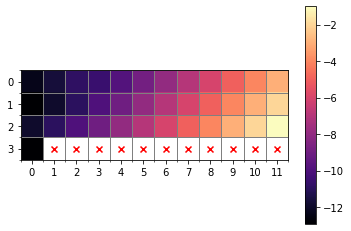

In [11]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()

num_episodes = 1000
alpha = 0.9
gamma = 0.999
epsilon = 0.1

# let's set a random seed
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

print('\n\n' + '-' * 30)
print('Q-Learning')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)

policy, Q = q_learning(rng,
                       cliff_env, 
                       num_episodes, 
                       gamma=gamma, 
                       alpha=alpha, 
                       epsilon=epsilon)
# V = td_policy_evaluation(rng, cliff_env, policy, num_episodes, gamma=gamma, alpha=alpha)
V = defaultdict(lambda: 0)
for s, qs in Q.items():
    V[s] = np.max(qs)

gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

## (4) Expected SARSA

In [12]:
def expected_sarsa(rng: np.random._generator.Generator, 
                        env: gym.Env, 
                        num_episodes: int, 
                        gamma: float=0.999, 
                        alpha: float=0.1,
                        epsilon: float=0.1
    ) -> Dict[int, float]:
    """
    EXPECTED SARSA algorithm, which calculates the value function
    and a policy.
    
    Args:
        rng: random number generators
        env: the openai gym environment
        num_episodes: number of episodes to sample
        gamma: the discount factor
        alpha: step size
        epsilon: probability of random action
    
    Returns:
        the policy 
        the state-action value function
    """
    # this is how we store the state-action value function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # this is simply a helper array that helps us sample from available actions, given a policy
    actions = np.arange(env.action_space.n)
    
    for si in range(1, num_episodes + 1):
        if si % 10000 == 0:
            print('{}/{} Episodes'.format(si, num_episodes))

        state = env.reset()
        done = False
        while not done:
            greedy_policy = eps_greedy_from_qs(rng,Q[state],epsilon)
            action =  rng.choice(actions, p=greedy_policy)

            new_state,reward,done,_ = env.step(action = action)
            
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * np.sum(greedy_policy * Q[new_state]) - Q[state][action])

            state = new_state
        



    # after all the episodes, there might be states missing from 'policy', as exploration
    # could have missed some states. so if we have not encountered a state yet, behave randomly
    policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # make a deterministic policy, based on the Q values
    for s, qs in Q.items():
        policy[s] = np.eye(env.action_space.n)[np.argmax(qs)]
    return policy, Q





In [13]:
# let's create an environment
cliff_env = gym.make('Cliff-v0')

num_episodes = 1
alpha = 0.9
gamma = 0.999
epsilon = 0.1

# let's set a random seed
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
policy, Q = expected_sarsa(rng, 
                            cliff_env, 
                            num_episodes,
                            gamma,
                            alpha, 
                            epsilon)

assert len(Q) > 0, "Your implementation generates an empty value function"
for state, val in Q.items():
    assert testing.is_type(state, [np.int64, int])
    assert testing.is_type(val, np.ndarray)


### Setup and Run


FFFFFFFFFFFF
FFFFFFFFFFFF
FFFFFFFFFFFF
SHHHHHHHHHHG


------------------------------
Expected SARSA
num_episodes 1000
alpha 0.9
gamma 0.999


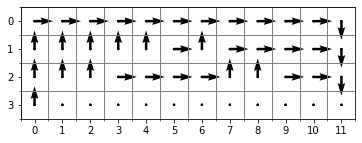

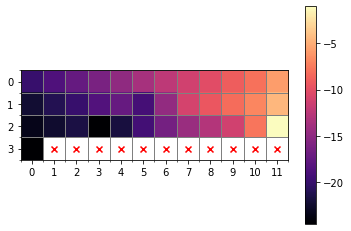

In [14]:
cliff_env = gym.make('Cliff-v0')
cliff_env.render()


# aha - this is interesting! expected SARSA needs much less episodes
# than SARSA!
num_episodes = 1000
alpha = 0.9
gamma = 0.999
epsilon = 0.1

# let's set a random seed
seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

### Run Algorithm

print('\n\n' + '-' * 30)
print('Expected SARSA')
print('num_episodes', num_episodes)
print('alpha', alpha)
print('gamma', gamma)
policy, Q = expected_sarsa(rng, 
                           cliff_env, 
                           num_episodes, 
                           gamma=gamma, 
                           alpha=alpha, 
                           epsilon=epsilon)

# V = td_policy_evaluation(cliff_env, policy, num_episodes, gamma=gamma)
V = defaultdict(lambda: 0)
for s, qs in Q.items():
    V[s] = np.max(qs)
    
gg.plot_policy(cliff_env, policy)
gg.plot_value_function(cliff_env, V, vmax=-1)

### Theory questions

Answer whether the following statements are true or false (1 point each question)

1. TD methods require a model of the environment (i.e., the dynamics and reward function)
2. TD(0) uses bootstrapping (i.e., they update the value function using previous estimates of the value function)
3. TD and Monte Carlo methods are similar in that they need to wait until the end of an episode to compute updates
4. In practice, TD methods converge faster than Monte Carlo methods on stochastic tasks
5. An off-policy version of Expected Sarsa is equivalent to Q-learning if the target policy is greedy.
6. In the standard Q-learning update ($Q(S,A) \leftarrow Q(S, A) + \alpha [R + \gamma \max_a Q(S', a) - Q(S, A)]$) taking the maximum over previous estimates of $Q$ **does not** lead to positive bias.

In [15]:
# store True or False
results = {
  "1" : False,
  "2" : True,
  "3" : False,
  "4" : True,
  "5" : True,
  "6" : False,
}


Anser the following questions in **one, short sentence**.
1. Q-learning is considered an off-policy method. What are the target and behavior policies in Q-Learning? (2 points)

Target policy - is a policy we want to improve and Behaviour policy - is a policy y used to generate episodes.

2. In the cliff walking example: Why does SARSA return a 'safe' path? You may want to consult the book, Example 6.6 if you are stuck. (2 point)

Because SARSA is on policy method, sometimes it chooses not optimal actions for explorations, which could lead to -100 reward (because of fall-down) if you go through optimal path.

Store True/ False into the provided variable.
- Which of the above algorithms will result in an optimal policy for the cliff walking environment (assuming an epsilon-greedy policies (target & behaviour) with constant epsilon)?

In [22]:
sarsa = False # store true/ false
q_learning = True # store true/ false
expected_sarsa = False # store true/ false

In [23]:
assert testing.is_type(sarsa, bool)
assert testing.is_type(q_learning, bool)
assert testing.is_type(expected_sarsa, bool)